<a href="https://colab.research.google.com/github/krisivarga/deep_learning_HW_big/blob/main/LSTM_Text_Class_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#download file from web

import requests, zipfile, io, os

zip_file_url = "http://groups.di.unipi.it/~gulli/newsspace200.xml.bz"

filename = zip_file_url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(zip_file_url)
    f.write(r.content)

In [3]:
#create data folder, decompress data

import bz2,shutil

dirName = 'data'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
    
with bz2.BZ2File("newsspace200.xml.bz") as fr, open("./data/input.xml","wb") as fw:
    shutil.copyfileobj(fr,fw)

Directory  data  already exists


In [4]:
import xml.etree.ElementTree as ET

tree = ET.parse("./data/input.xml")
root = tree.getroot()

titles = []
categories = []
descriptions = []
sources = []


for title in tree.findall('title'):
    titles.append(title.text)
    
for category in tree.findall('category'):
        categories.append(category.text)

for description in tree.findall('description'):
    descriptions.append(description.text)

for source in tree.findall('source'):
    sources.append(source.text)


In [5]:
import numpy as np

In [6]:
titles = np.array(titles).T
categories = np.array(categories).T
descriptions = np.array(descriptions).T
sources = np.array(sources).T

In [7]:
data = np.dstack((sources,titles,descriptions,categories)).reshape(len(titles),4)

In [8]:
import pandas as pd

df = pd.DataFrame(data)
df.columns = ['source','title', 'desc', 'cat']

In [9]:
#select number of categories
num_cat = 5
selected_cats = df['cat'].value_counts()[:num_cat].index.tolist()

df_selected = df.loc[df['cat'].isin(selected_cats)]


In [10]:
df_selected = df_selected.dropna()

In [11]:
!pip install sentencepiece
!pip install transformers
from transformers import XLNetTokenizer
from transformers import BertTokenizer
import re

regex = re.compile('^[a-zA-Z]{3,}$')

xltokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

btokenizer = BertTokenizer.from_pretrained("bert-base-uncased")



In [12]:
def tr(bt,reg,title,sz):
  a = bt.tokenize(title + " " + sz)
  r = []
  for s in a:
    if reg.match(s) is not None:     
      r.append(s)      
  return r

df_selected['berttoken'] = df_selected.apply(lambda row: tr(btokenizer, regex, str(row['title']), str(row['desc'])), axis=1)


In [13]:
def bertenc(bt,title,sz):
  text_to_encode = title + " " + sz
  a = bt.encode_plus(
            text_to_encode, 
            max_length= 64, 
            add_special_tokens=True,
            return_token_type_ids=False, 
            padding="max_length",
            truncation = True,
            return_attention_mask=False
        )
  ids = a['input_ids']  
  return ids

df_selected['bertencodeplus'] = df_selected.apply(lambda row: bertenc(btokenizer, str(row['title']), str(row['desc'])), axis=1)


In [14]:
bertencidvoc_dict = {}
bertvoc_dict = {}
def dict_creater(arr):
  for a in arr:
    if a != 0:
      if a in bertencidvoc_dict:
        count = bertencidvoc_dict[a] + 1
        bertencidvoc_dict.update({a:count})
      else:
        bertencidvoc_dict.update({a:1})
  return

def dict_creater2(arr):
  for a in arr:
    if a != 0:
      if a in bertvoc_dict:
        count = bertvoc_dict[a] + 1
        bertvoc_dict.update({a:count})
      else:
        bertvoc_dict.update({a:1})
  return

df_selected.apply(lambda row: dict_creater(row['bertencodeplus']), axis=1)

df_selected.apply(lambda row: dict_creater2(row['berttoken']), axis=1)


0         None
1         None
2         None
3         None
4         None
          ... 
496829    None
496830    None
496831    None
496832    None
496833    None
Length: 324797, dtype: object

We encoded the categories with numbers, so they're easier to work with.

In [15]:
i = 0
category_dictionary = {}
cat_rev_dict= {}
for s in selected_cats:
  category_dictionary.update({i:s})
  cat_rev_dict.update({s:i})
  i = i + 1


df_selected['cat_enc'] = df_selected.apply(lambda row: cat_rev_dict[str(row['cat'])] , axis=1)


In [16]:
# Since the goal of this exercise if to identify category based on headline and short description, 
# we choose to merge them, as the vectorizer functions can't process multiple columns

#df_selected['joined'] = df_selected.apply(lambda row: " ".join(row['berttoken']) , axis=1)
X = np.array(df_selected["bertencodeplus"].values.tolist())
#X = df_selected['bertencodeplus'].to_numpy()
y = df_selected['cat_enc'].to_numpy()

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into 70-30 i.e. test size of 30% to check the accuracy of the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle = True)

#Let's check the shape of the splitted data
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (227357, 64)
Testing Data Shape: (48720, 64)


In [18]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [19]:
Y_train = to_categorical(y_train, num_classes=5, dtype='float32')
Y_test = to_categorical(y_test, num_classes=5, dtype='float32')
Y_valid = to_categorical(y_valid, num_classes=5, dtype='float32')

In [20]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dIsf_-kNjWo6vRtm_DPsbebZpZRhEzzd' -O 'best_LSTM_CONV1D_model.h5'

--2021-12-12 11:28:46--  https://docs.google.com/uc?export=download&id=1dIsf_-kNjWo6vRtm_DPsbebZpZRhEzzd
Resolving docs.google.com (docs.google.com)... 142.251.8.113, 142.251.8.101, 142.251.8.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.8.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6un5nsgdjcovevvidbudj9oei8lvjujd/1639308525000/16722052510491764536/*/1dIsf_-kNjWo6vRtm_DPsbebZpZRhEzzd?e=download [following]
--2021-12-12 11:28:48--  https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6un5nsgdjcovevvidbudj9oei8lvjujd/1639308525000/16722052510491764536/*/1dIsf_-kNjWo6vRtm_DPsbebZpZRhEzzd?e=download
Resolving doc-0k-68-docs.googleusercontent.com (doc-0k-68-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to doc-0k-68-docs.googleusercontent.com (doc-0k-68-docs

In [21]:
best_model = keras.models.load_model("best_LSTM_CONV1D_model.h5")

In [30]:
from keras.utils.vis_utils import plot_model

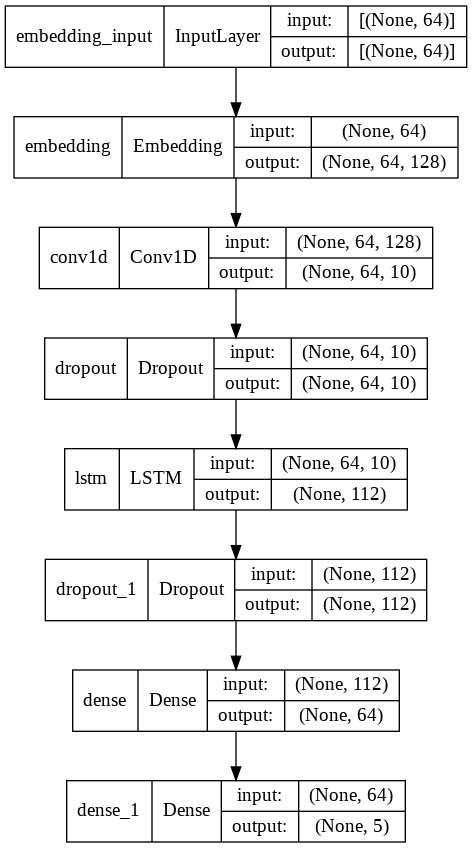

In [31]:
plot_model(best_model, show_shapes=True, show_layer_names=True)

In [32]:
best_model.evaluate(X_test,Y_test)

1523/1523 [==============================] - 14s 9ms/step - loss: 0.7742 - accuracy: 0.6713


[0.7741839289665222, 0.6713054180145264]

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [34]:
preds = best_model.predict(X_test)
y_pred=np.argmax(preds,axis=1)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75     12259
           1       0.54      0.49      0.52     10610
           2       0.76      0.97      0.85      9277
           3       0.72      0.92      0.81      8214
           4       0.30      0.00      0.00      8360

    accuracy                           0.67     48720
   macro avg       0.59      0.65      0.59     48720
weighted avg       0.60      0.67      0.60     48720



In [35]:
conf_mat = confusion_matrix(y_test, y_pred)
target_names = ['World','Entertainment','Sports','Business','Top Stories']

In [36]:
conf_mat_df = pd.DataFrame(conf_mat,
                     index = target_names, 
                     columns = target_names)

In [37]:
conf_mat_df

,World,Entertainment,Sports,Business,Top Stories
World,10885,683,188,501,2
Entertainment,2808,5241,1309,1249,3
Sports,103,102,9010,62,0
Business,236,336,73,7567,2
Top Stories,2622,3307,1337,1091,3


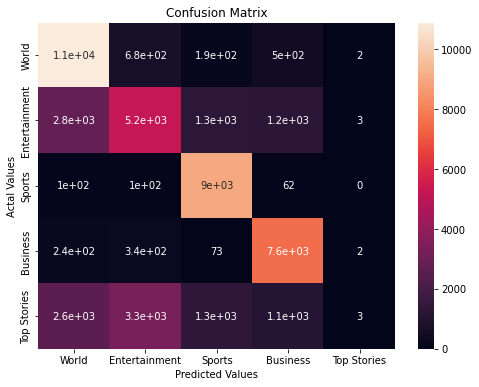

In [38]:
#Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()